# Bernstein-Vazirani Algorithm
This algorithm attempts to retrieve data out of a blackbox that has been encoded with a binary string.

## Imports

In [1]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit.providers.ibmq import least_busy
#IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

## The Oracle Circuit
This circuit will use CNOT gates to encode our binary string, the extra qubit is used as the target for all of the CNOT calculations. The bit string is reversed and every one is encoded as a qubit in a CNOT operation, every zero is left alone.

In [2]:
def bv_oracle(blackboxVal):
    qc = QuantumCircuit(len(blackboxVal)+1) #one extra qubit for calculation
    
    for i, val in enumerate(reversed(blackboxVal)):
        if val == '1':
            qc.cx(i, len(blackboxVal))
    
    return qc

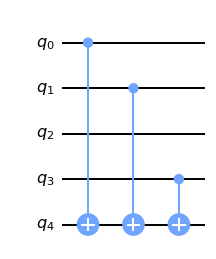

In [6]:
blackboxVal = '1011'
qc = bv_oracle(blackboxVal)
qc.draw(output='mpl')

## The Bernstein-Vazirani Circuit
This is the same circuit as the Deutsch-Jozsa algorithm, the only difference is how we construct the oracle. If we know how the oracle is encoded but not necessarily what is inside, we can deduce different information. In this case, we can retrieve a binary string from within the blackbox.

In [5]:
def bernsteinVaz(val):
    qc = QuantumCircuit(len(val)+1, len(val)) #one extra qubit for calculation
    
    qc.h(range(len(val)))
    
    qc.x(len(val))
    qc.h(len(val))

    oracle = bv_oracle(val)
    oracle = oracle.to_gate()
    oracle.name = "Oracle"
    qc.append(oracle, range(len(val) + 1))

    qc.h(range(len(val)))

    qc.measure(range(len(val)), range(len(val)))
    
    return qc

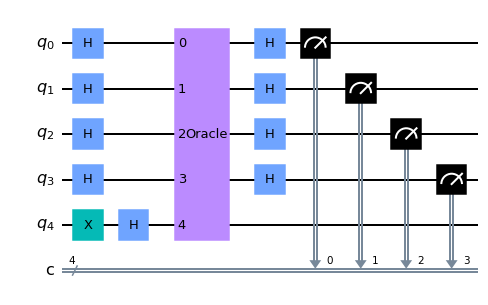

In [8]:
blackboxVal = '1011'
qc = bernsteinVaz(blackboxVal)
qc.draw(output='mpl')

## Simulating the Algorithm
Under ideal circumstances, we can deduce the encoded string with certainty without looking inside the blackbox.

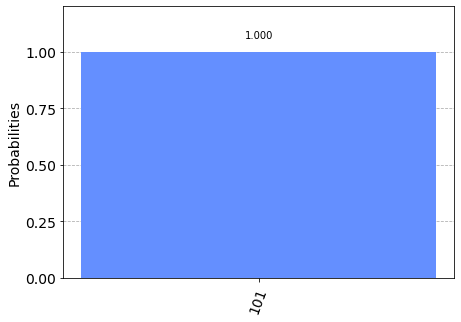

In [6]:
blackboxVal = '101'
qc = bernsteinVaz(blackboxVal)

sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)

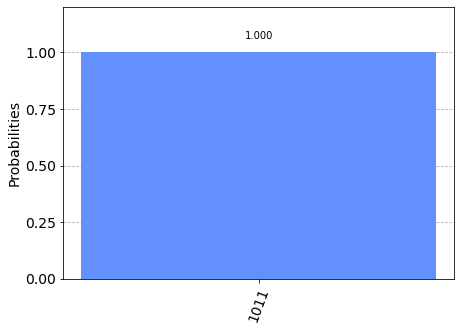

In [7]:
blackboxVal = '1011'
qc = bernsteinVaz(blackboxVal)

sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)

## Executing in Reality
With high probability we can determine the encoded string. But it should be noted that as the length of the string increases the more difficult it will become to infer any information from the noise and errors that will occur from a larger circuit.

In [51]:
blackboxVal = '101'
qc = bernsteinVaz(blackboxVal)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= len(blackboxVal)+1 and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

Least busy:  ibm_oslo


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

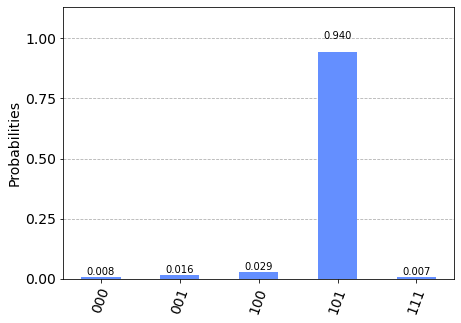

In [52]:
counts = job.result().get_counts()
plot_histogram(counts)

In [10]:
blackboxVal = '1011'
qc = bernsteinVaz(blackboxVal)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= len(blackboxVal)+1 and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

Least busy:  ibmq_belem


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

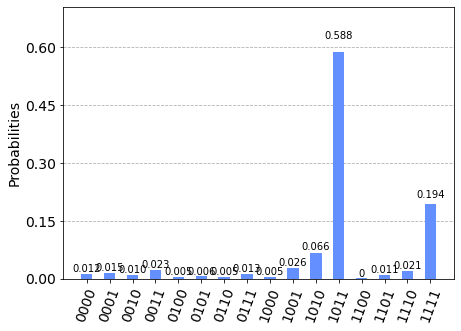

In [11]:
counts = job.result().get_counts()
plot_histogram(counts)